<a href="https://colab.research.google.com/github/guilhermecarva/guilhermecarva/blob/main/VAE_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoder (VAE)

O Variational Autoencoder (VAE) é uma extensão do autoencoder tradicional, que adiciona uma camada de inferência probabilística para modelar a distribuição dos dados latentes. Em resumo, um VAE é um Autoencoder cuja distribuição de codificações é regularizada durante o treinamento, a fim de garantir que seu espaço latente tenha boas propriedades, o que nos permite gerar novos dados.

O VAE consiste em duas partes principais: o encoder e o decoder. O encoder mapeia a entrada para uma distribuição de probabilidade no espaço latente, enquanto o decoder mapeia amostras desse espaço latente de volta para a saída. O objetivo do VAE é aprender a distribuição dos dados latentes e gerar novos dados a partir dessa distribuição.


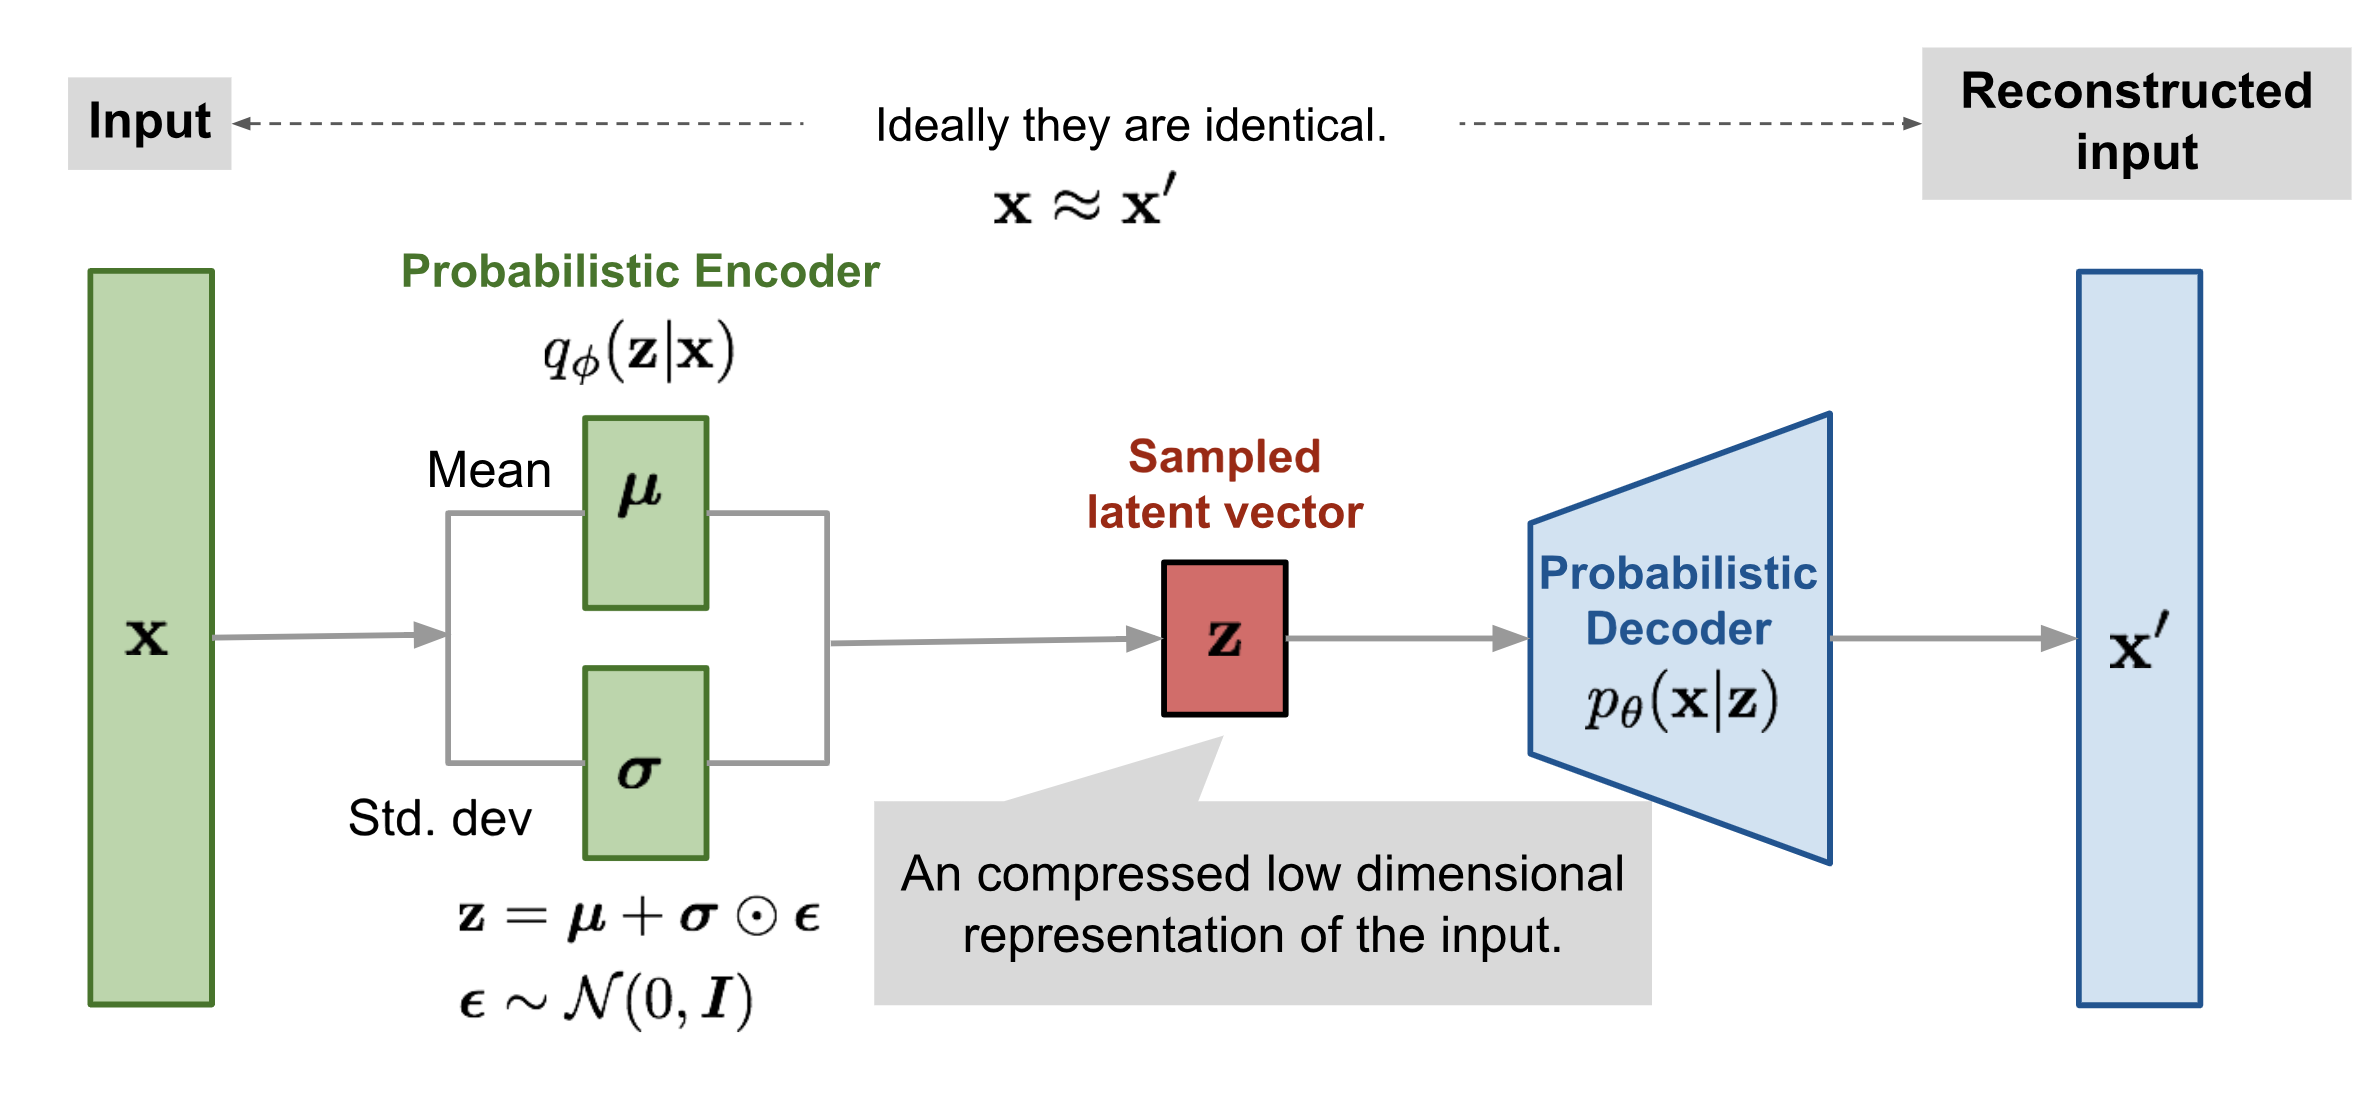

Vamos começar importanto as bibliotecas que iremos utilizar

In [ ]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras import losses
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

Extraindo as imagens do arquivo zip que está no google drive

In [ ]:
path_from = "/content/drive/MyDrive/Mentorama/coil100.zip"

path_to = "coil100/"

with ZipFile(path_from, 'r') as zipp:
    zipp.extractall(path_to)

Como temos alguns arquivo que não são imagens no nosso diretório, para não termos problemas, iremos considerar apenas arquivos com extensão png

In [ ]:
image_dir = "/content/coil100/coil-100/coil-100/"
included_extensions = ['png']
filenames = [fn for fn in os.listdir(image_dir)
              if any(fn.endswith(ext) for ext in included_extensions)]

labels = [x.split("_")[0] for x in filenames]
ext = [x.split(".")[1] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels, "ext":ext})
#data = data.query('ext=="png"')

print(data.head(),len(data))

         filename  label  ext
0   obj70__45.png  obj70  png
1  obj86__165.png  obj86  png
2  obj37__120.png  obj37  png
3  obj23__115.png  obj23  png
4  obj80__110.png  obj80  png 7200


Temos agora um dataset com 7200 imagens divididos em 100 classes conforme mostra figura abaixo

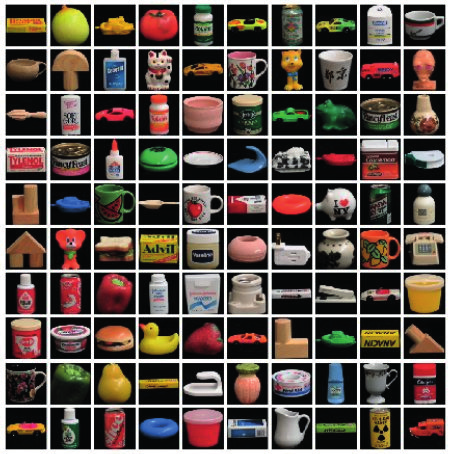

Vamos converter as imagens em um array numpy do tipo uint8

In [ ]:
images = []
for pic_file in tqdm(filenames[:len(data)]):
    pic = Image.open(image_dir  + pic_file)
    images.append(np.uint8(pic))

100%|██████████| 7200/7200 [00:05<00:00, 1216.85it/s]


Já sabemos o tamanho das imagens, pois consta na documentação de origem. No entanto, vamos confirmar qual a média do tamanho das imagens.

In [ ]:
image_width = []
image_height = []
x=0
while x < len(data['filename']):
    image = cv2.imread(os.path.join(image_dir,data['filename'][x]))
    height, width, _ = image.shape
    image_width.append(width)
    image_height.append(height)
    x = x+1
    #print(height, width)

median_width = np.median(image_width)
median_height = np.median(image_height)


print('median_size:', median_width,  'X', median_height)

median_size: 128.0 X 128.0


Dividindo nosso dataset em treino e teste

In [ ]:
x_train, x_test , y_train, y_test= train_test_split(images, data['label'],test_size=0.33, random_state=42)

Vamos normalizar nossos batchs. ( aqui poderíamos utilizar o batchnormalization do keras )

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
print(x_train.shape,x_test.shape)

(4824, 128, 128, 3) (2376, 128, 128, 3)


In [ ]:
x_train.dtype

dtype('uint8')

In [ ]:
#normalizando
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = x_train.shape[3]
input_shape = (img_height, img_width, num_channels)

In [ ]:
print(input_shape)

(128, 128, 3)


# Construindo o modelo

Vamos definir nosso encoder

In [ ]:
latent_dim = 2 # dimensão do vetor gaussiano que será utilizado como input no gerador

input_img = Input(shape=input_shape,name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x) #este é o shape do conv para ser utilizado no decoder
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

In [ ]:
x.shape

TensorShape([None, 32])

In [ ]:
print(conv_shape)

(None, 64, 64, 64)


Conforme representado na figura do início, temos duas variáveis que representam o espaço latente por onde os inputs são mapeados. São eles : média e desvio padrão.

In [ ]:
z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)

Vamos definir a amostra do vetor latente, aqui representado por Z. <br> Isso permitirá que o gradiente descendente faça uma estimação com acurácia.

In [ ]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps


A última camada de nosso modelo será a camada Lambda, onde Z será utilizado para os cálculos do gradiente descendente.

In [ ]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

Instanciamos o encoder.

In [ ]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

Definindo o Decoder

O input para o decoder será o vetor latente. Para termos o mesmo shape da imagem original, vamos começar com o shape do conv que definimos anteriormente.

In [ ]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape para o shape da última camada do conv do encoder
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale para o shape original
x = Dense(64, activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same',activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', strides=1, activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Definindo o modelo
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 262144)            786432    
                                                                 
 reshape (Reshape)           (None, 64, 64, 64)        0         
                                                                 
 dense_4 (Dense)             (None, 64, 64, 64)        4160      
                                                                 
 conv2d_transpose (Conv2DTr  (None, 128, 128, 32)      18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 32)      9248      
 Transpose)                                                

In [ ]:
x.shape

TensorShape([None, 128, 128, 3])

Aplicando o decoder na amostra latente.

In [ ]:
z_decoded = decoder(z)
print(input_img.shape,z_decoded.shape)

(None, 128, 128, 3) (None, 128, 128, 3)


Instanciando o modelo

In [ ]:
#del vae

In [ ]:
vae = Model(input_img, z_decoded, name='vae')

#compilando o VAE
vae.compile(optimizer='adam', loss=losses.MeanSquaredError())
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d_1[0][0]']            
                                                                                                

Podemos verificar que o shape da imagem original ( de entrada ) é o mesmo da imagem de saída do nosso modelo

Treinando o modelo

In [ ]:
vae.fit(x_train, x_train, epochs = 10, batch_size = 64, validation_data = (x_test,None))

Epoch 1/10
76/76 [==============================] - 41s 273ms/step - loss: 0.0514 - val_loss: 0.0000e+00
Epoch 2/10
76/76 [==============================] - 18s 239ms/step - loss: 0.0278 - val_loss: 0.0000e+00
Epoch 3/10
76/76 [==============================] - 18s 243ms/step - loss: 0.0237 - val_loss: 0.0000e+00
Epoch 4/10
76/76 [==============================] - 19s 244ms/step - loss: 0.0223 - val_loss: 0.0000e+00
Epoch 5/10
76/76 [==============================] - 19s 251ms/step - loss: 0.0214 - val_loss: 0.0000e+00
Epoch 6/10
76/76 [==============================] - 19s 254ms/step - loss: 0.0208 - val_loss: 0.0000e+00
Epoch 7/10
76/76 [==============================] - 19s 255ms/step - loss: 0.0201 - val_loss: 0.0000e+00
Epoch 8/10
76/76 [==============================] - 20s 259ms/step - loss: 0.0198 - val_loss: 0.0000e+00
Epoch 9/10
76/76 [==============================] - 19s 256ms/step - loss: 0.0194 - val_loss: 0.0000e+00
Epoch 10/10
76/76 [==============================] - 19

In [ ]:
c_list = list(map(lambda x: x, range(0, len(y_test))))
print(len(c_list), len(y_test))

2376 2376


Vamos criar um scatter plot de 2 dimensões para vermos qual o tamanho e como se comporta o espaço latente

75/75 [==============================] - 1s 13ms/step


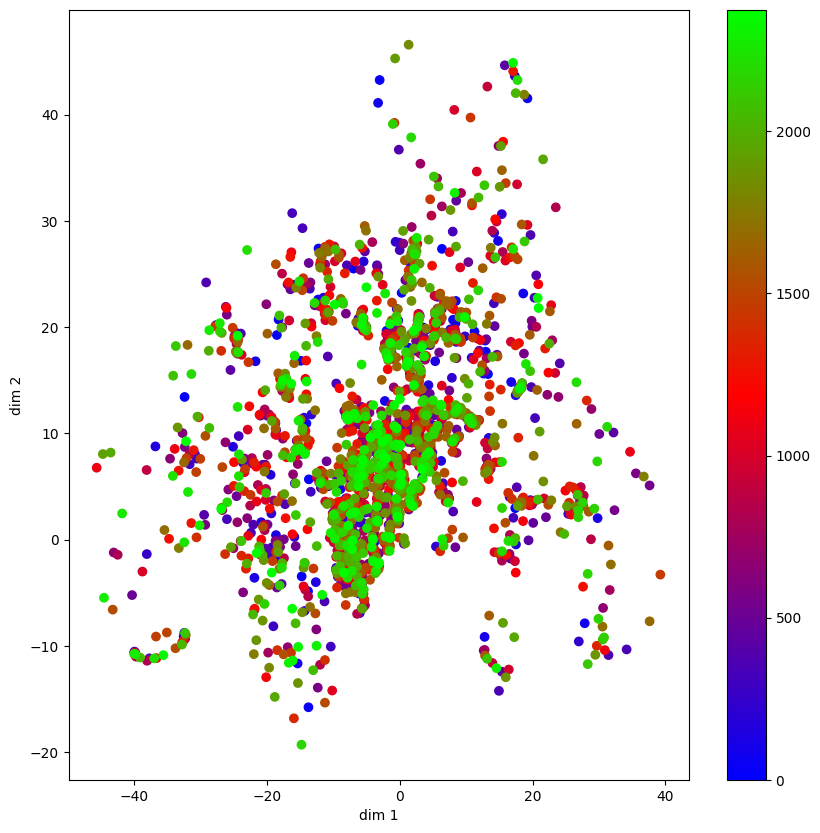

In [ ]:
mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=c_list, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

Podemos ver uma concentração no centro do espaço latente, mas temos uma dispersão considerável nos demais espaços

## Vamos plotar 10 imagens originais e compará-las com as imagens reconstruídas para vermos se o modelo foi bem construído e treinado

In [ ]:
predict = vae.predict(x_test)

75/75 [==============================] - 4s 40ms/step


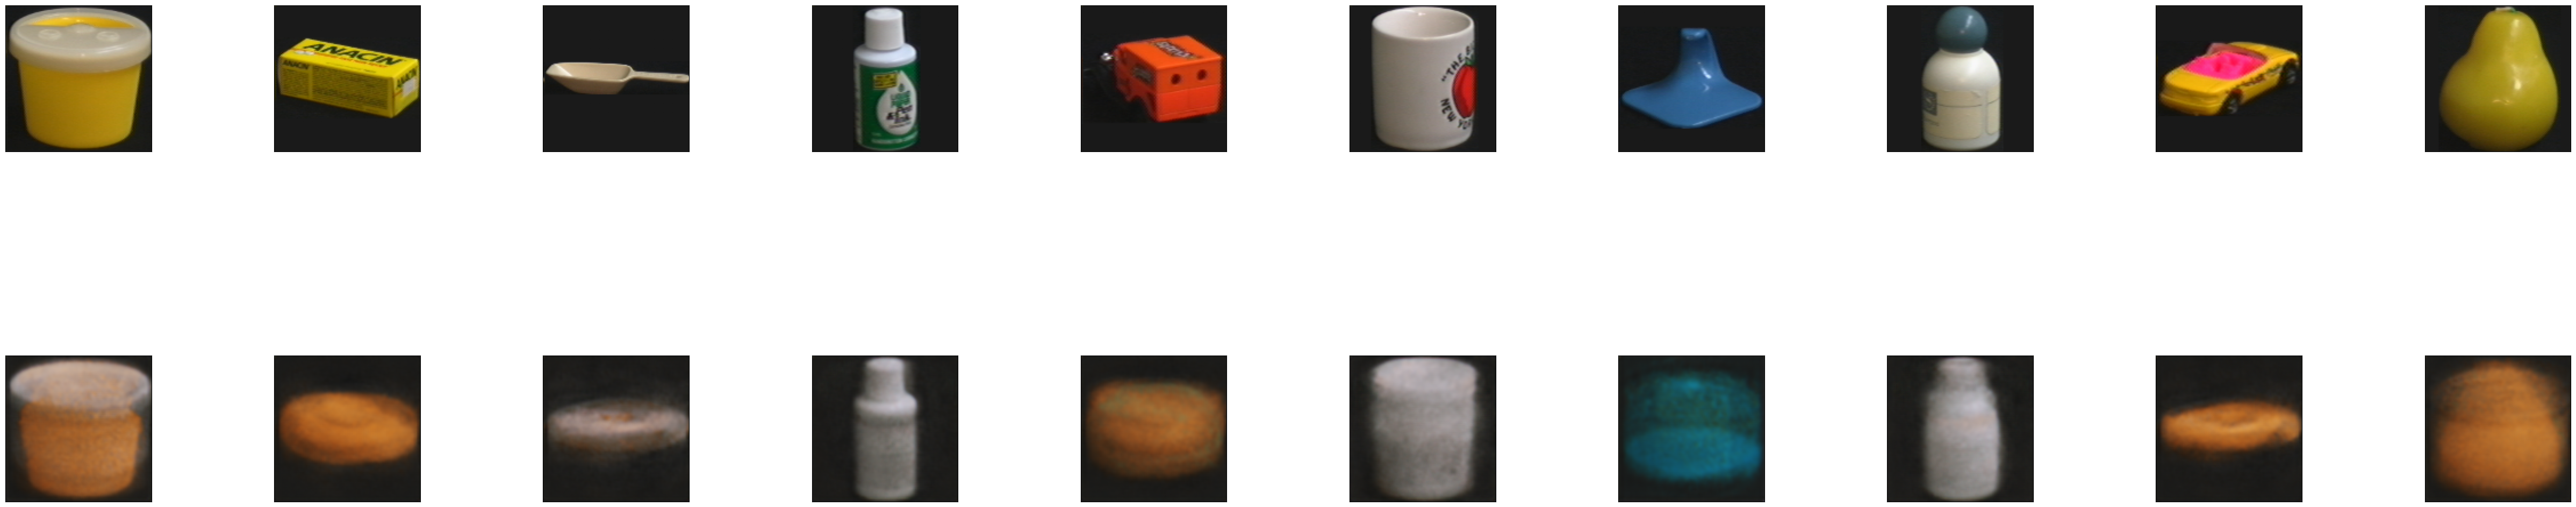

In [ ]:
plt.figure(figsize=(128,12))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(128, 128,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predict[i].reshape(128, 128,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

###Aparentemento o objetivo foi alcançado com **SUCESSO**

Vamos escolher um ponto específico do espaço latente para plotarmos uma imagem do decoder. Como por exemplo o vetor (10,10)

1/1 [==============================] - 0s 56ms/step


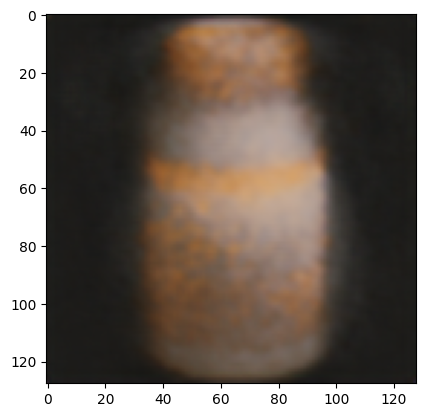

In [ ]:
sample_vector = np.array([[10,10]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height,num_channels)
plt.imshow(decoded_example_reshaped)

Agora vamos "passear" entre 2 vetores para vermos como saímos de um e chegamos no outro. vetor 1 ----->>>> vetor 2

In [ ]:
%%capture
n = 10
figure = np.zeros((img_width * n, img_height * n, num_channels))

#vamos escolher um espaço entre 2 vetores
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(0, 10, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))

fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1],fig_shape[2]))

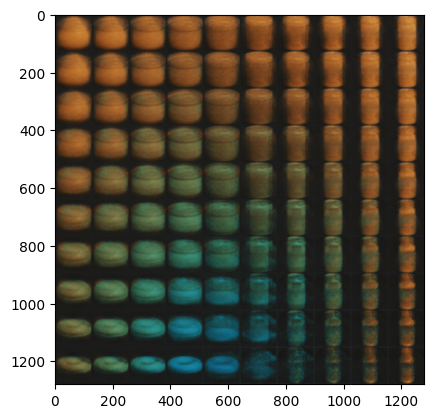

In [ ]:
plt.imshow(figure, cmap='gnuplot2')
plt.show()

Na figura acima podemos verificar o caminho percorrido no espaço latente entre 2 objetos

Por fim vamos fazer o mesmo, só que agora de forma aleatória (gerando uma amostra randômica)

In [ ]:
%%capture
n = 30
img_size = 128
figure = np.zeros((img_size * n, img_size * n, num_channels))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, num_channels)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



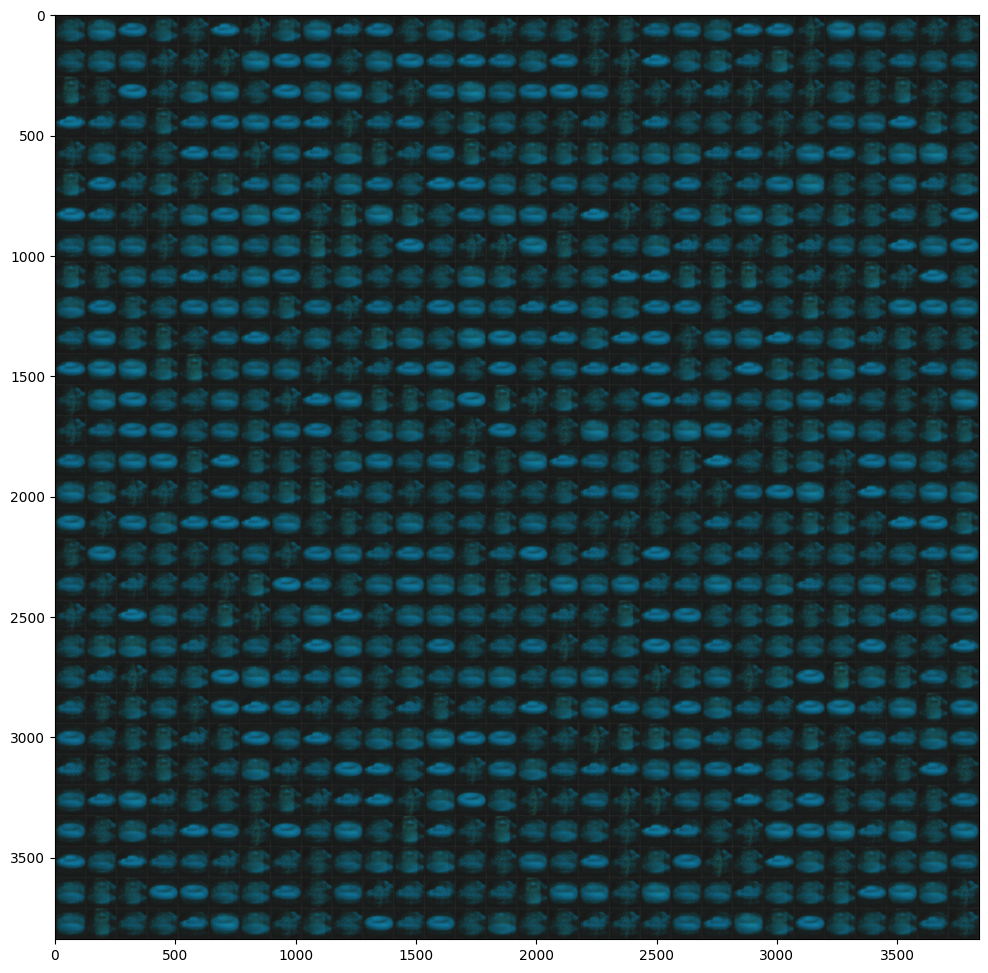

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(figure, cmap='gnuplot2')
plt.show()